# Guns & Smelling like ...

I wanted to take a look at the Jupyter Notebook. I also saw a graph [More Guns, More Gun Deaths by Mona Chalabi](https://www.instagram.com/p/BWk0pE-lKcH/?taken-by=mona_chalabi&hl=en).

The data in these calculations comes from the table [List of countries by firearm-related death rate](https://en.wikipedia.org/wiki/List_of_countries_by_firearm-related_death_rate) at Wikipedia and is augmented with some socioeconomic data from the [World bank](http://data.worldbank.org). The steps used to assemble the file '[gun_toters.feather](gun_toters.feather)' is available in [Guns - Data collection & cleanup](Guns%20-%20Data%20collection%20%26%20clean-up.ipynb).

## Preliminary thoughts
A thourough explanation of the theoretical foundatioins of this study can be found [here](https://www.youtube.com/watch?v=dQw4w9WgXcQ). And with that out of the way, let's dive right in to it!

In [6]:
import feather
path = 'gun_toters.feather'
gun_toters = feather.read_dataframe(path)
gun_toters.style

,Country,Deaths,Guns,Year,GDP,High-tech
0,JPN,0.06,0.6,2008,43603.1,23.8378
1,KOR,0.08,1.1,2011,17870.1,32.57
2,ROU,0.14,0.7,2012,6436.92,3.84505
3,QAT,0.15,19.2,2004,62518.3,0.00996628
4,SGP,0.16,0.5,2006,37790.3,56.7709
5,GBR,0.23,6.6,2011,38663,26.2167
6,BLR,0.23,7.3,2009,3772.01,3.10189
7,UKR,0.24,6.6,2009,2583.44,5.64661
8,POL,0.26,1.3,2011,9565.55,3.40018
9,IND,0.28,4.2,2014,908.143,5.91653


Let's do a quick graph.

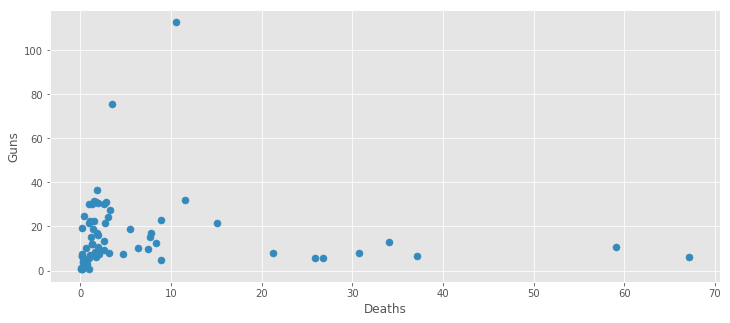

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = [12,5]

matplotlib.style.use('ggplot')
gun_toters_ax = gun_toters.plot.scatter(x='Deaths', y='Guns', s=50)
plt.show()

Not so brilliant ... But we do see sort of a pattern. Or three ...

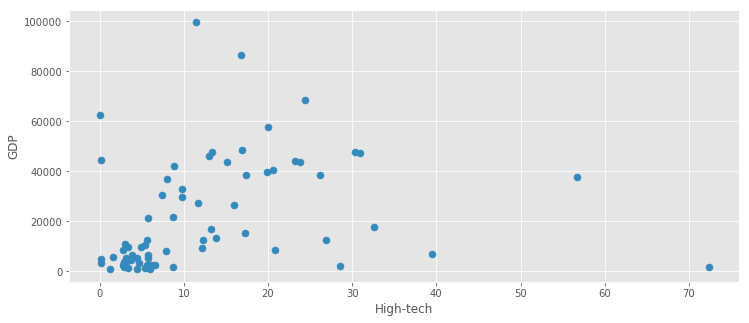

In [8]:
wb_values_ax = gun_toters.plot.scatter(x='High-tech', y='GDP', s=50)
plt.show()

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(gun_toters[['GDP', 'High-tech']])
gun_toters['Cluster'] = kmeans.labels_
gun_toters.style

,Country,Deaths,Guns,Year,GDP,High-tech,Cluster
0,JPN,0.06,0.6,2008,43603.1,23.8378,1
1,KOR,0.08,1.1,2011,17870.1,32.57,0
2,ROU,0.14,0.7,2012,6436.92,3.84505,0
3,QAT,0.15,19.2,2004,62518.3,0.00996628,2
4,SGP,0.16,0.5,2006,37790.3,56.7709,1
5,GBR,0.23,6.6,2011,38663,26.2167,1
6,BLR,0.23,7.3,2009,3772.01,3.10189,0
7,UKR,0.24,6.6,2009,2583.44,5.64661,0
8,POL,0.26,1.3,2011,9565.55,3.40018,0
9,IND,0.28,4.2,2014,908.143,5.91653,0


Not super helpful ... A colorised plot perhaps?

In [11]:
from matplotlib import colors
cluster_cmap = colors.ListedColormap(['#4369a5','#624e84','#893577'])

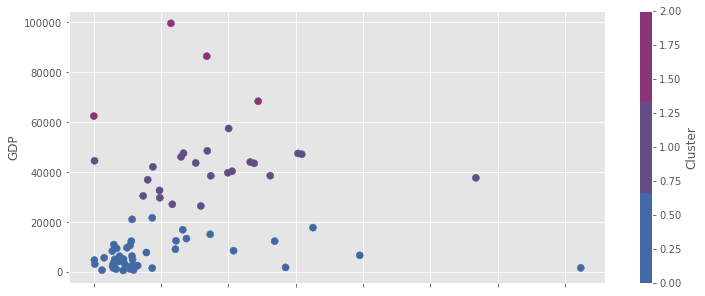

In [12]:
ax = gun_toters.plot.scatter(
    x='High-tech',
    y='GDP',
    c='Cluster',
    cmap = cluster_cmap,
    s=50)
plt.show()

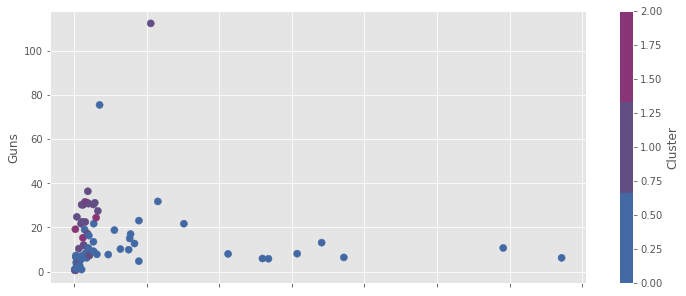

In [13]:
ax = gun_toters.plot.scatter(x='Deaths', y='Guns', c='Cluster', cmap = cluster_cmap, s=50)
plt.show()

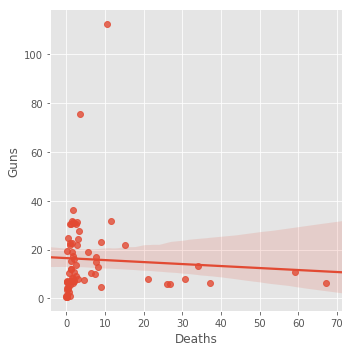

In [29]:
import seaborn as sns
sns.lmplot(x='Deaths', y='Guns', data=gun_toters, fit_reg=True)

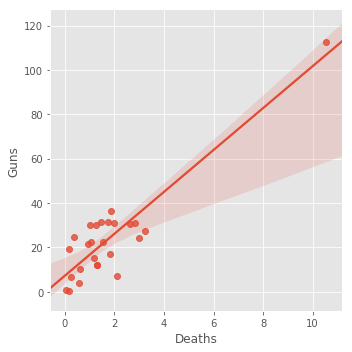

In [31]:
sns.lmplot(x='Deaths', y='Guns', data=gun_toters[gun_toters.Cluster != 0], fit_reg=True)

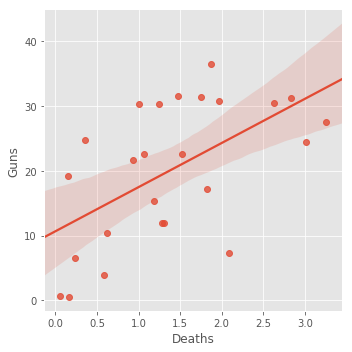

In [32]:
sns.lmplot(x='Deaths', y='Guns', data=gun_toters[(gun_toters.Cluster != 0) & (gun_toters.Country != "USA")], fit_reg=True)

Now we get to see the plot above with a socioeconomic overlay. Yey!

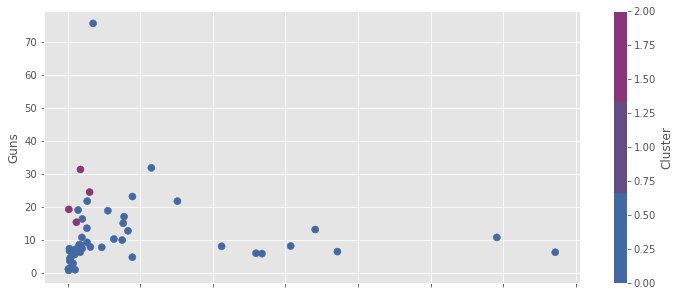

In [14]:
ax = gun_toters[gun_toters.Cluster != 1].plot.scatter(x='Deaths', y='Guns', c='Cluster', cmap = cluster_cmap, s=50)
plt.show()

For rich countries this seems very linear ...

In [15]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
rich_toters = gun_toters[gun_toters.Cluster != 1]
rich_model = lr.fit(rich_toters[['Guns']],rich_toters[['Deaths']])
rich_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
lr_wo_usa = LinearRegression()
rich_toters_wo_usa = gun_toters[(gun_toters.Cluster != 1) & (gun_toters.Country != 'USA')]
lr_wo_usa.fit(rich_toters_wo_usa[['Guns']],rich_toters_wo_usa[['Deaths']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
import statsmodels.api as sm
rich_model = sm.OLS(rich_toters[['Deaths']],rich_toters[['Guns']]).fit()
rich_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     5.942
Date:                Thu, 27 Jul 2017   Prob (F-statistic):             0.0187
Time:                        12:43:38   Log-Likelihood:                -198.16
No. Observations:                  47   AIC:                             398.3
Df Residuals:                      46   BIC:                             400.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Guns           0.3440      0.141      2.438      0.019       0.060       0.628
==============================================================================
Omnibus:                       34.933   Durbin-Watson:                   0.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.431
Skew:                           2.130   Prob(JB):                     2.08e-18
Kurtosis:                       7.841   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
import statsmodels.api as sm
rich_model_wo_usa = sm.OLS(rich_toters_wo_usa[['Deaths']],rich_toters_wo_usa[['Guns']]).fit()
rich_model_wo_usa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Deaths   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     5.942
Date:                Thu, 27 Jul 2017   Prob (F-statistic):             0.0187
Time:                        12:43:42   Log-Likelihood:                -198.16
No. Observations:                  47   AIC:                             398.3
Df Residuals:                      46   BIC:                             400.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Guns           0.3440      0.141      2.438      0.019       0.060       0.628
==============================================================================
Omnibus:                       34.933   Durbin-Watson:                   0.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.431
Skew:                           2.130   Prob(JB):                     2.08e-18
Kurtosis:                       7.841   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And we take the different regressions we have created and put them into the plot.

[  1.1    0.7   19.2    7.3    6.6    1.3    4.2    3.5    4.6    2.8    5.5
   0.9    7.1   15.3   19.     8.5    6.2   31.3    8.3   10.7    7.3   16.3
  13.5    9.2   21.7   24.45   7.8   75.6    7.7   18.8   10.2    9.9   15.
  17.    12.7    4.7   23.1   31.8   21.7    8.     5.9    5.8    8.1   13.1
   6.4   10.7    6.2 ]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: shapes (1,47) and (1,1) not aligned: 47 (dim 1) != 1 (dim 0)

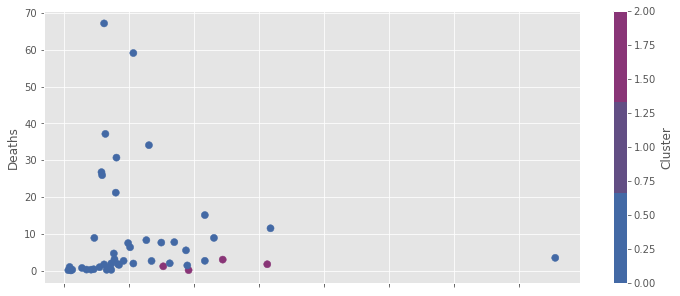

In [27]:
X = rich_toters['Guns'].values
ax = rich_toters.plot.scatter(x='Guns', y='Deaths', c='Cluster', cmap = cluster_cmap, s=50)
plt.plot(X, lr_wo_usa.predict(X), color='blue', linewidth=3)
plt.plot(X, lr.predict(X), color='red', linewidth=3)
plt.plot(X, rich_model.predict(X), color='pink', linewidth=3)
plt.plot(X, rich_model_wo_usa.predict(X), color='lightblue', linewidth=3)
plt.show()

From this we learn atleast three things.
1. The 'scikit-learn' and the 'statsmodels' linear regression methods differ.
1. In a rich country increasing the number of guns results in more deaths by guns. Who'd a thunk it?
1. The elevated death-rate in the US is higher than it should be for a wealthy country with it's shit together. But yeah ...

In [119]:
gun_toters[gun_toters.Cluster == 2]

,Country,Deaths,Guns,Year,GDP,High-tech,Cluster
C2,,,,,,,
QA,Qatar,0.15,19.20,2004.0,62518.316634,0.009966,2
LU,Luxembourg,1.19,15.30,2011.0,99612.567971,11.463384,2
NO,Norway,1.75,31.30,2012.0,86465.847954,16.787543,2
CH,Switzerland,3.01,24.45,2015.0,68445.874561,24.425477,2


In [136]:
gun_toters[(gun_toters.Cluster == 0) & (gun_toters.Deaths > 10)].sort_values('GDP').drop(['Year','Cluster'], axis=1)

,Country,Deaths,Guns,GDP,High-tech
C2,,,,,
US,United States,10.54,112.6,47557.977337,30.332926


In [137]:
gun_toters[gun_toters.Cluster == 1].sort_values('GDP').drop(['Year','Cluster'], axis=1)

,Country,Deaths,Guns,GDP,High-tech
C2,,,,,
KG,Kyrgyzstan,1.01,0.9,740.401432,4.365969
ZW,Zimbabwe,0.39,4.6,869.537154,1.225840
IN,India,0.28,4.2,908.142940,5.916530
MD,Moldova,1.03,7.1,1283.224569,3.321189
NI,Nicaragua,4.68,7.7,1384.541593,5.347349
BO,Bolivia,0.74,2.8,1678.045161,8.679206
HN,Honduras,67.18,6.2,1736.859567,2.914155
PH,Philippines,8.90,4.7,1758.800864,72.352023
GE,Georgia,1.98,7.3,1971.254999,28.495451


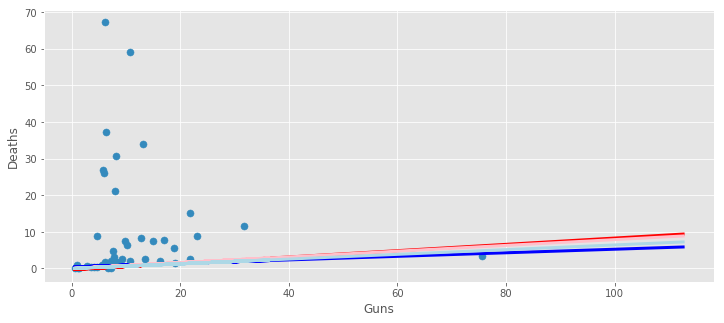

In [138]:
poor_toters = gun_toters[gun_toters.Cluster == 1]
ax = poor_toters.plot.scatter(x='Guns', y='Deaths', s=50)
plt.plot(X, lr_wo_usa.predict(X), color='blue', linewidth=3)
plt.plot(X, lr.predict(X), color='red', linewidth=3)
plt.plot(X, rich_model.predict(X), color='pink', linewidth=3)
plt.plot(X, rich_model_wo_usa.predict(X), color='lightblue', linewidth=3)
plt.show()

Here we sort of follow the same pattern for some of the points. Could be interesting to cluster this group. Or increase the number of clusters above.

In [140]:
poor_toters[poor_toters.Deaths > 10].drop(['Year','Cluster'], axis=1)

,Country,Deaths,Guns,GDP,High-tech
C2,,,,,
UY,Uruguay,11.52,31.8,8515.755998,2.762607
PA,Panama,15.11,21.7,5810.007791,1.539080
BR,Brazil,21.20,8.0,9238.322919,12.130622
CO,Colombia,25.94,5.9,5132.672316,5.766862
SV,El Salvador,26.77,5.8,3230.708824,4.625133
JM,Jamaica,30.72,8.1,4903.662668,0.086861
GT,Guatemala,34.10,13.1,2615.976462,6.062451
SZ,Swaziland,37.16,6.4,3273.632987,0.159722
VE,Venezuela,59.13,10.7,11077.990259,2.986381


## The End ...
It would be interesting to add all violent deaths to the numbers. The yanks tend to say that their guns prevent more death than they cause and if this is the case the other rich countries should have a disproportionate number of stabbings, bludgeonings and so on. To compensate for their inability to shoot people.

Perhaps this will be added later. If I find the data.